In [13]:
%cd /kaggle/input/project-2/project2
!pip install torch_geometric

/kaggle/input/project-2/project2


In [14]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data

from utils.GNN_data import *
from utils.GNN_architecture import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=32, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./saved_model', help='saved GNN model directory')
args = parser.parse_args([])

In [16]:

def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, E=np.float64(label * 200.00))
    return data

# Data loading

In [17]:
import os
from glob import glob

folder_list = ['Hexagonal', 'Kagome', 'Demi-A', 'Demi-B', 'Demi-C']
base_path = '.'  

dataset = []

for folder in folder_list:
    results_path = os.path.join(base_path, folder, 'Results.txt')
    inp_folder = os.path.join(base_path, folder, 'inp_files')

    # Parse Results.txt in the current folder
    file_labels = {}
    with open(results_path, 'r') as file:
        for line in file:
            if line.strip() == "" or "E/Es" in line:
                continue
            try:
                file_name, label = line.strip().split(', ')
                filename = file_name.strip().split('.')[0]
                label = float(label)
                file_labels[filename] = label
            except ValueError:
                print(f"[{folder}] Skipping invalid line: {line.strip()}")

    # Load each corresponding .inp file
    for file, label in file_labels.items():
        file_path = os.path.join(inp_folder, f"{file}.inp")
        if os.path.exists(file_path):
            data = load_inp_data(file_path, label)
            if data is not None:
                dataset.append(data)
        else:
            print(f"[{folder}] Missing file: {file_path}")

In [18]:
dataset

[Data(x=[84, 2], edge_index=[2, 108], E=0.0372903386912),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0373225123404),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372565315822),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037280152510000004),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0373298610736),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037282611876399994),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372536721102),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372684650144),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037290959038799996),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0373284772212),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372660240018),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037260987807),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372693129452),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037302903483),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037280112132400005),
 Data(x=[84, 2], edge_index=[2, 108], E=0.0372893035548),
 Data(x=[84, 2], edge_index=[2, 108], E=0.037310615615

In [19]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 19804
Number of test graphs: 2475
Number of vali graphs: 2476


In [20]:
dataset[0]

Data(x=[84, 2], edge_index=[2, 216], E=0.0372903386912)

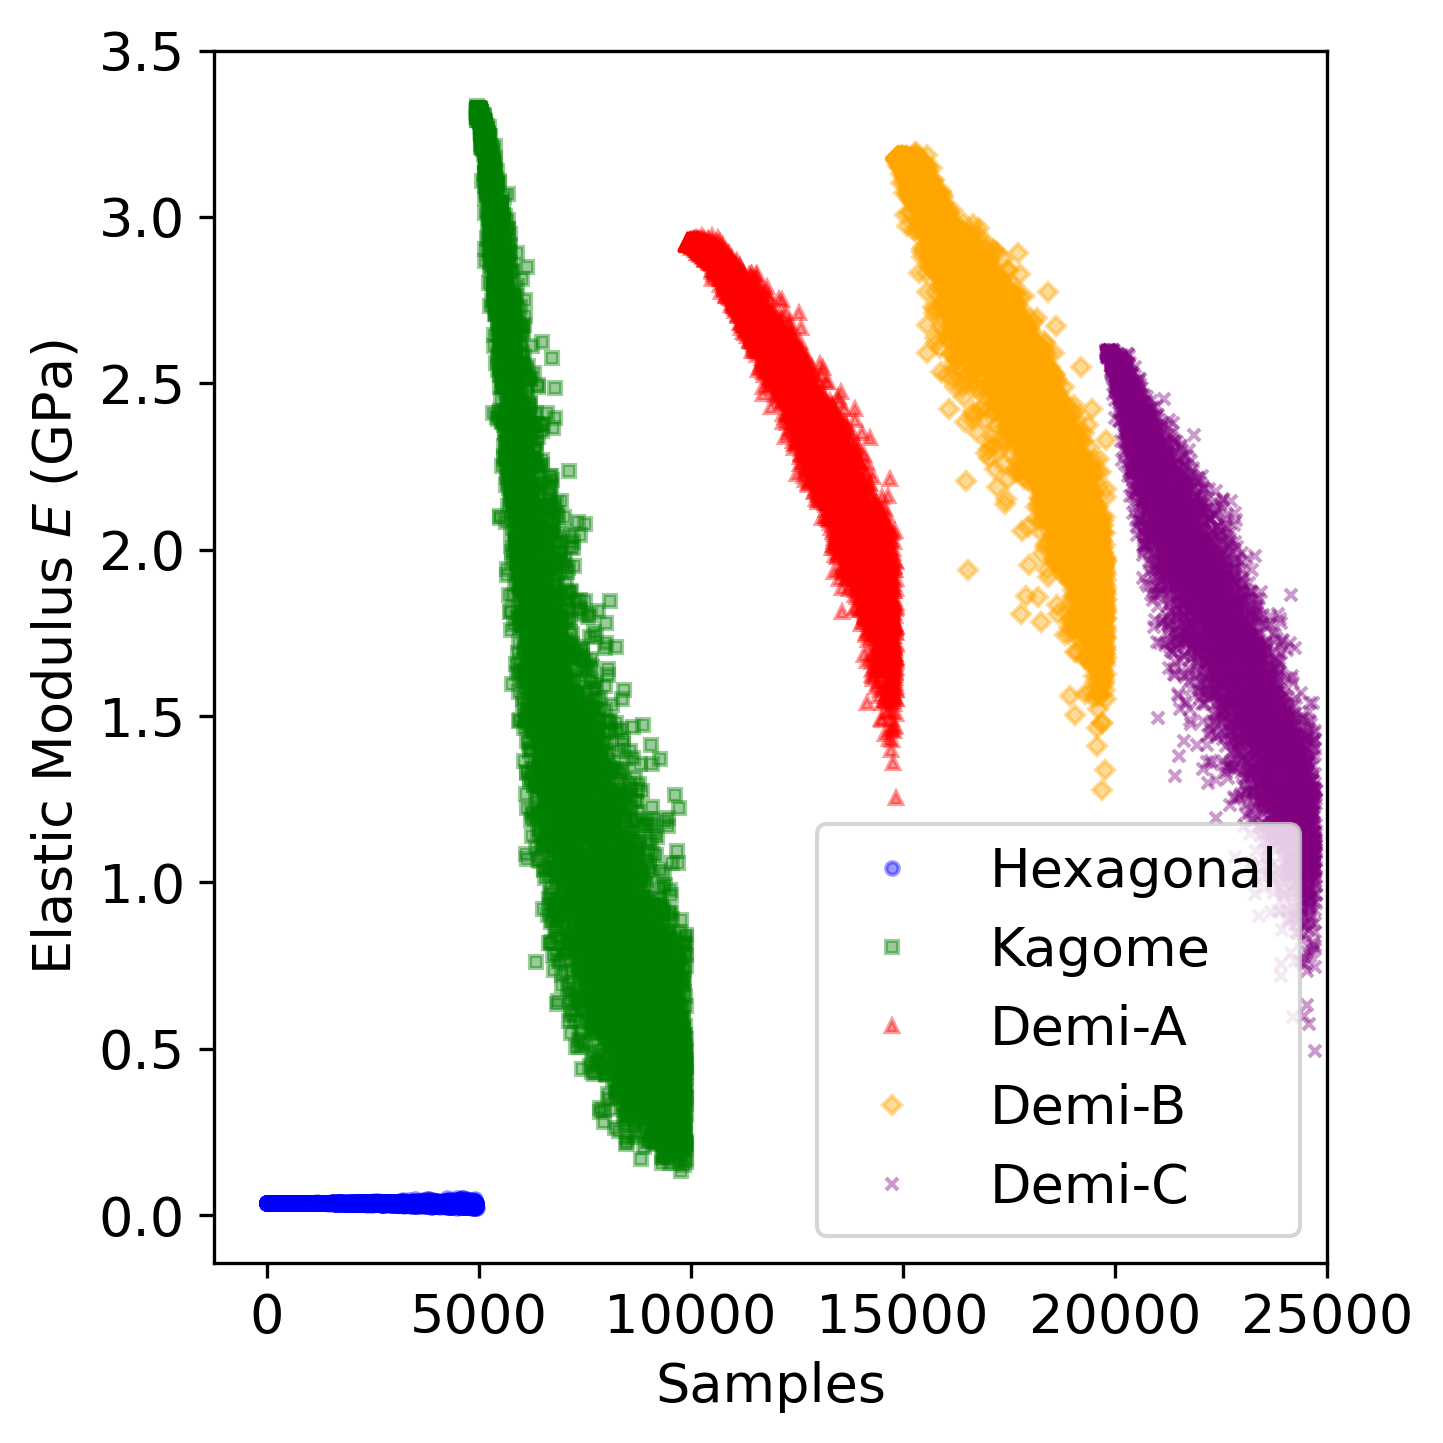

In [21]:
E_vals = [data.E for data in dataset]

plt.figure(figsize=(5,5), dpi=300) 

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 13

labels = ['Hexagonal', 'Kagome', 'Demi-A', 'Demi-B', 'Demi-C']
markers = ['o', 's', '^', 'D', 'x']  # circle, square, triangle, diamond, cross
colors = ['blue', 'green', 'red', 'orange', 'purple']

size = 4951
for i in range(5):
    start = i * size
    end = (i + 1) * size
    x = range(start, end)
    y = E_vals[start:end]
    
    plt.plot(x, y, linestyle='none', marker=markers[i], color=colors[i],
             markersize=3, label=labels[i], alpha=0.4)

plt.ylabel(r'Elastic Modulus $E$ (GPa)')
plt.xlabel('Samples')
plt.xlim(right=25000)
plt.ylim(top=3.5)
plt.legend()
plt.tight_layout() 

# GNN model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv, CGConv, GATv2Conv, TransformerConv, NNConv
from torch_geometric.nn import global_add_pool, global_mean_pool

class Transformer(torch.nn.Module):
    def __init__(self, dim_h, node_feature, heads=4):
        super(Transformer, self).__init__()
        self.conv1 = TransformerConv(node_feature, dim_h, heads=heads)
        self.conv2 = TransformerConv(dim_h * heads, dim_h, heads=heads)
        self.conv3 = TransformerConv(dim_h * heads, dim_h, heads=heads)

        self.lin1 = Linear(dim_h * heads * 3, dim_h * 2)
        self.lin2 = Linear(dim_h * 2, dim_h * 2)
        self.lin3 = Linear(dim_h * 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h1 = self.relu(h1)
        h2 = self.conv2(h1, edge_index)
        h2 = self.relu(h2)
        h3 = self.conv3(h2, edge_index)
        h3 = self.relu(h3)

        h1 = global_mean_pool(h1, batch)
        h2 = global_mean_pool(h2, batch)
        h3 = global_mean_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.relu(self.lin1(h))
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.relu(self.lin2(h))
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin3(h)

        return h.squeeze()


In [23]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = Transformer(dim_h=64, node_feature=no_node_feature)
#model = GIN(dim_h=64, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-5)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

Transformer(
  (conv1): TransformerConv(2, 64, heads=4)
  (conv2): TransformerConv(256, 64, heads=4)
  (conv3): TransformerConv(256, 64, heads=4)
  (lin1): Linear(in_features=768, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)
Number of parameters: 644481


## Training

In [24]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], LR [0.001], Loss[Train: 1.152, Test: 0.764], R2[Train: -0.051, Test: 0.290]
Epoch [2], LR [0.001], Loss[Train: 0.324, Test: 0.177], R2[Train: 0.704, Test: 0.836]
Epoch [3], LR [0.001], Loss[Train: 0.251, Test: 0.327], R2[Train: 0.771, Test: 0.696]
Epoch [4], LR [0.001], Loss[Train: 0.269, Test: 0.152], R2[Train: 0.754, Test: 0.859]
Epoch [5], LR [0.001], Loss[Train: 0.212, Test: 0.124], R2[Train: 0.806, Test: 0.884]
Epoch [6], LR [0.001], Loss[Train: 0.190, Test: 0.172], R2[Train: 0.826, Test: 0.840]
Epoch [7], LR [0.001], Loss[Train: 0.185, Test: 0.083], R2[Train: 0.831, Test: 0.923]
Epoch [8], LR [0.001], Loss[Train: 0.153, Test: 0.121], R2[Train: 0.860, Test: 0.887]
Epoch [9], LR [0.001], Loss[Train: 0.152, Test: 0.162], R2[Train: 0.861, Test: 0.850]
Epoch [10], LR [0.001], Loss[Train: 0.138, Test: 0.073], R2[Train: 0.874, Test: 0.933]
Epoch [11], LR [0.001], Loss[Train: 0.129, Test: 0.160], R2[Train: 0.882, Test: 0.851]
Epoch [12], LR [0.001], Loss[Train: 0.116, Test: 0.

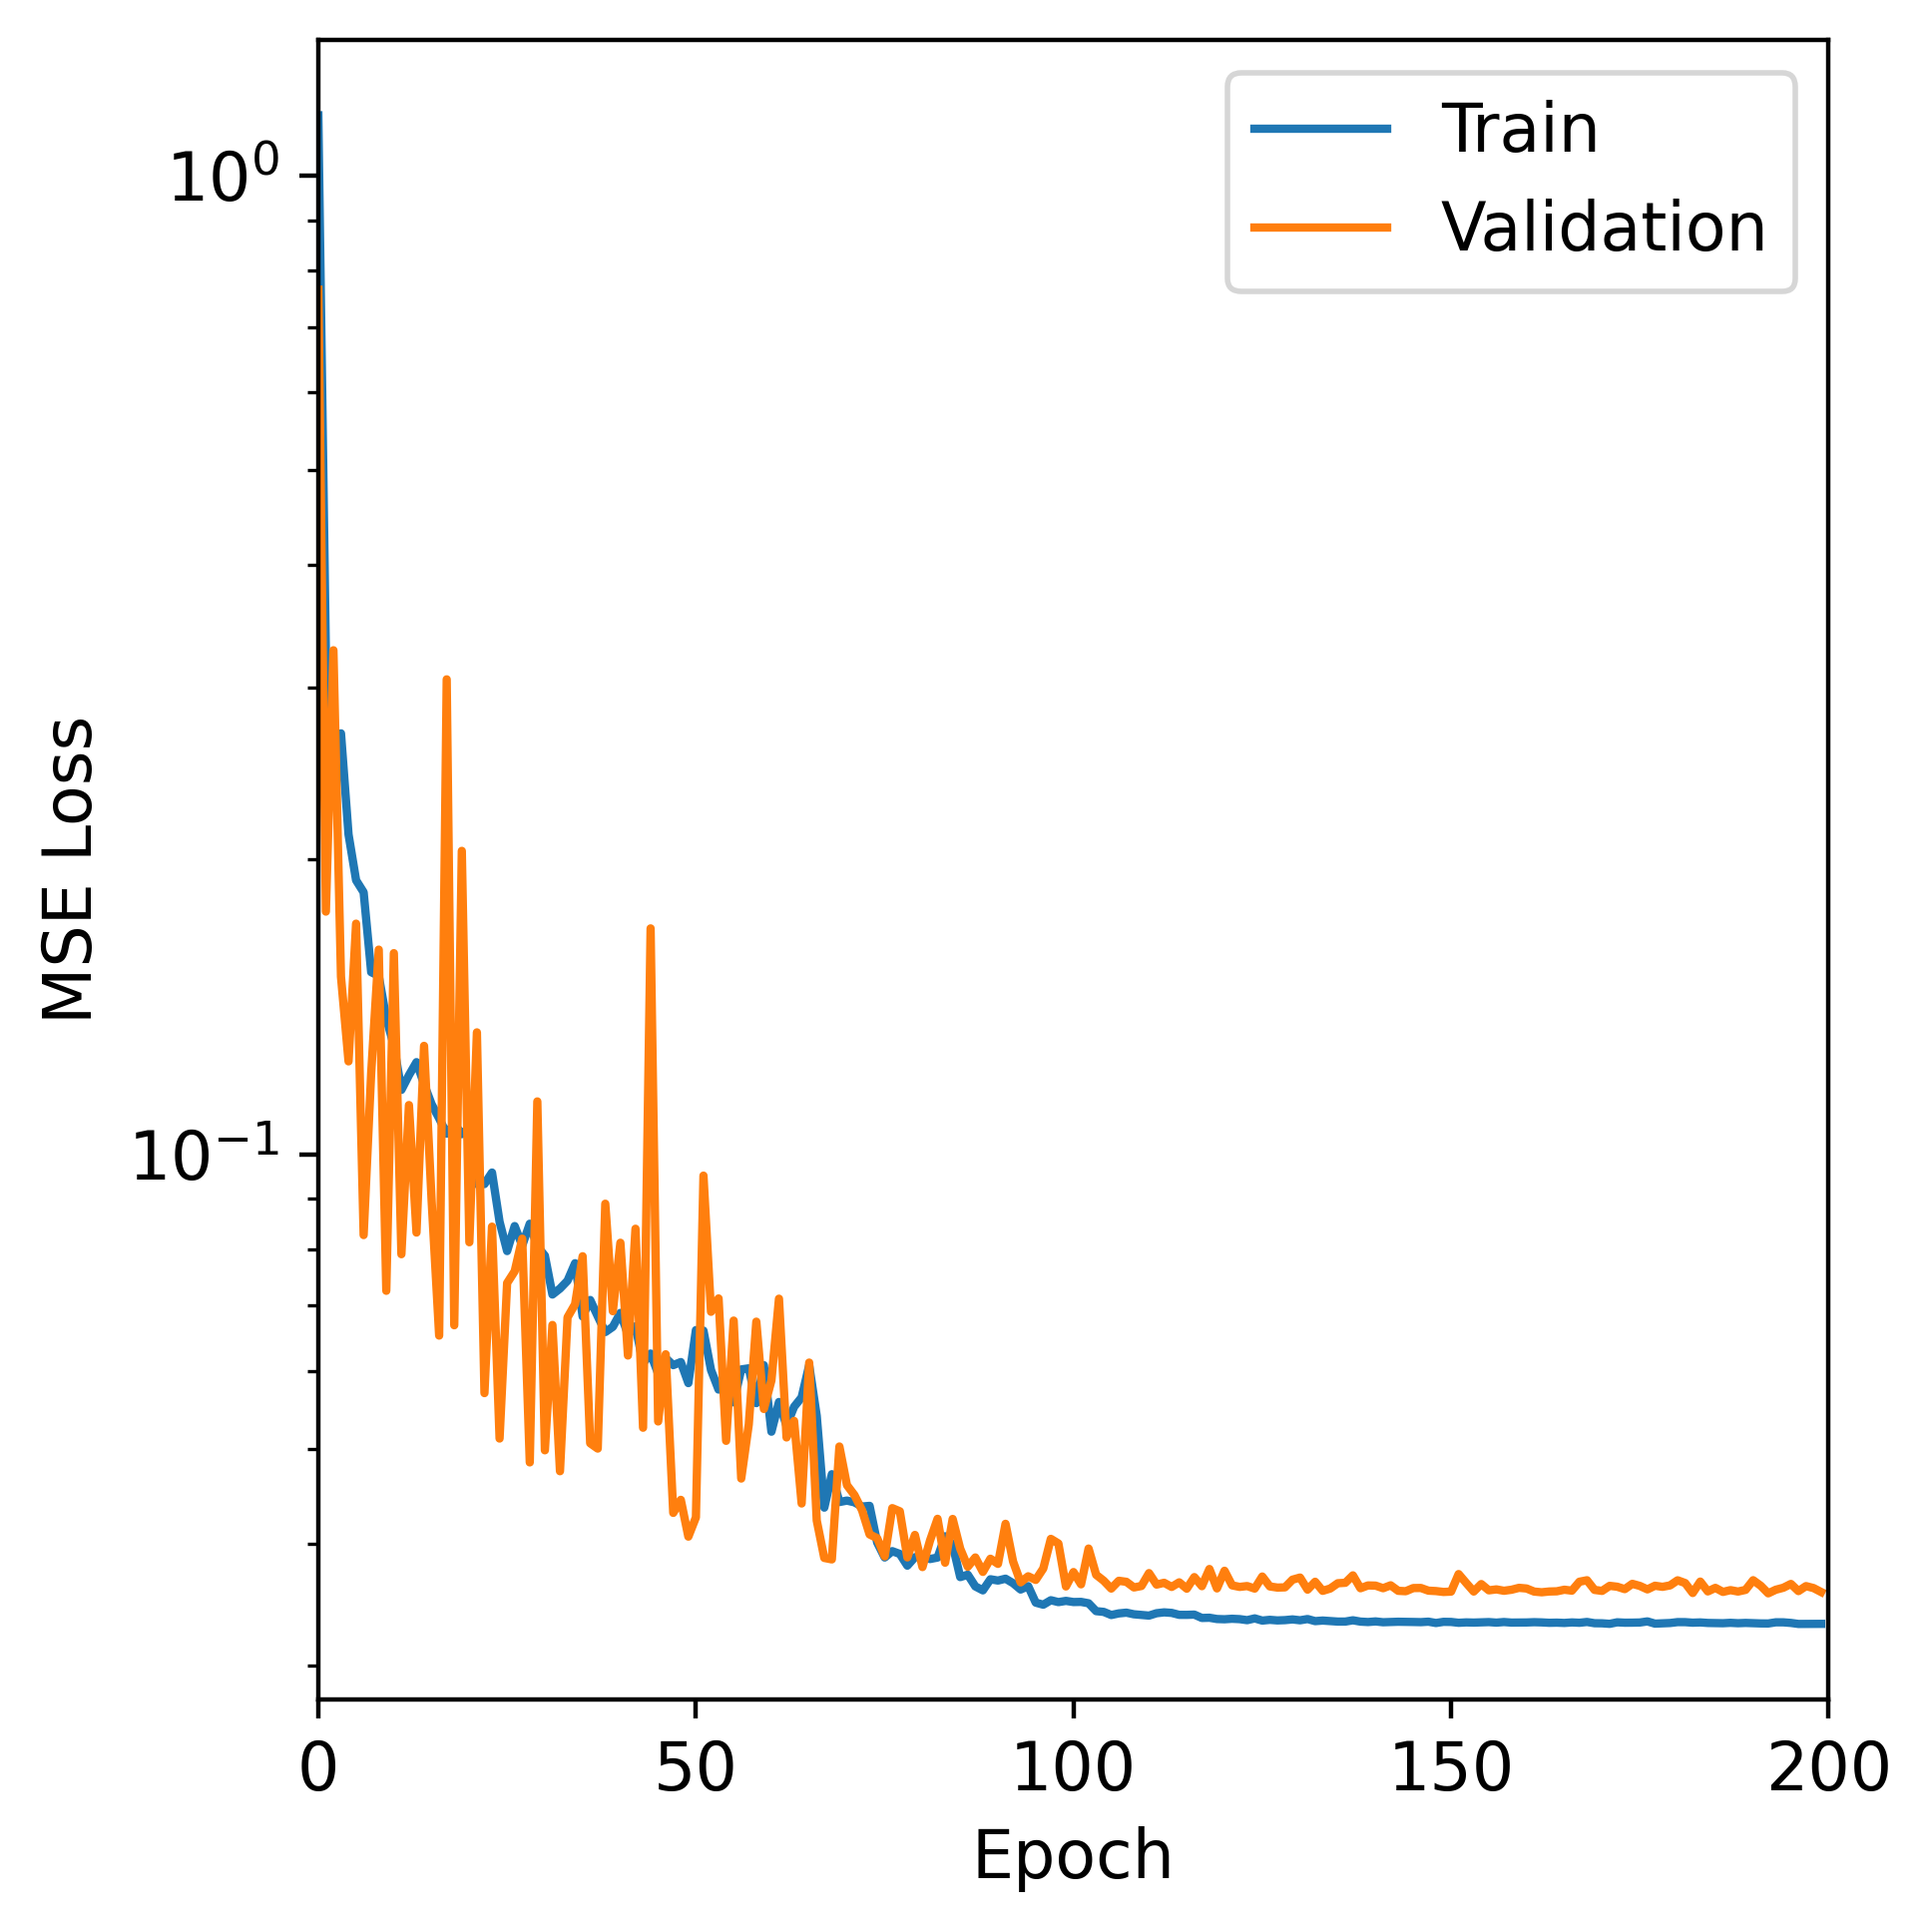

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5), dpi=400) 

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale("log") 
plt.xlim(0,epoch_num)
plt.tight_layout() 

# Save model

In [26]:
best_model_path = f'/kaggle/working/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

## Training and Validation data

Test R2 for E: 0.9696429065343096


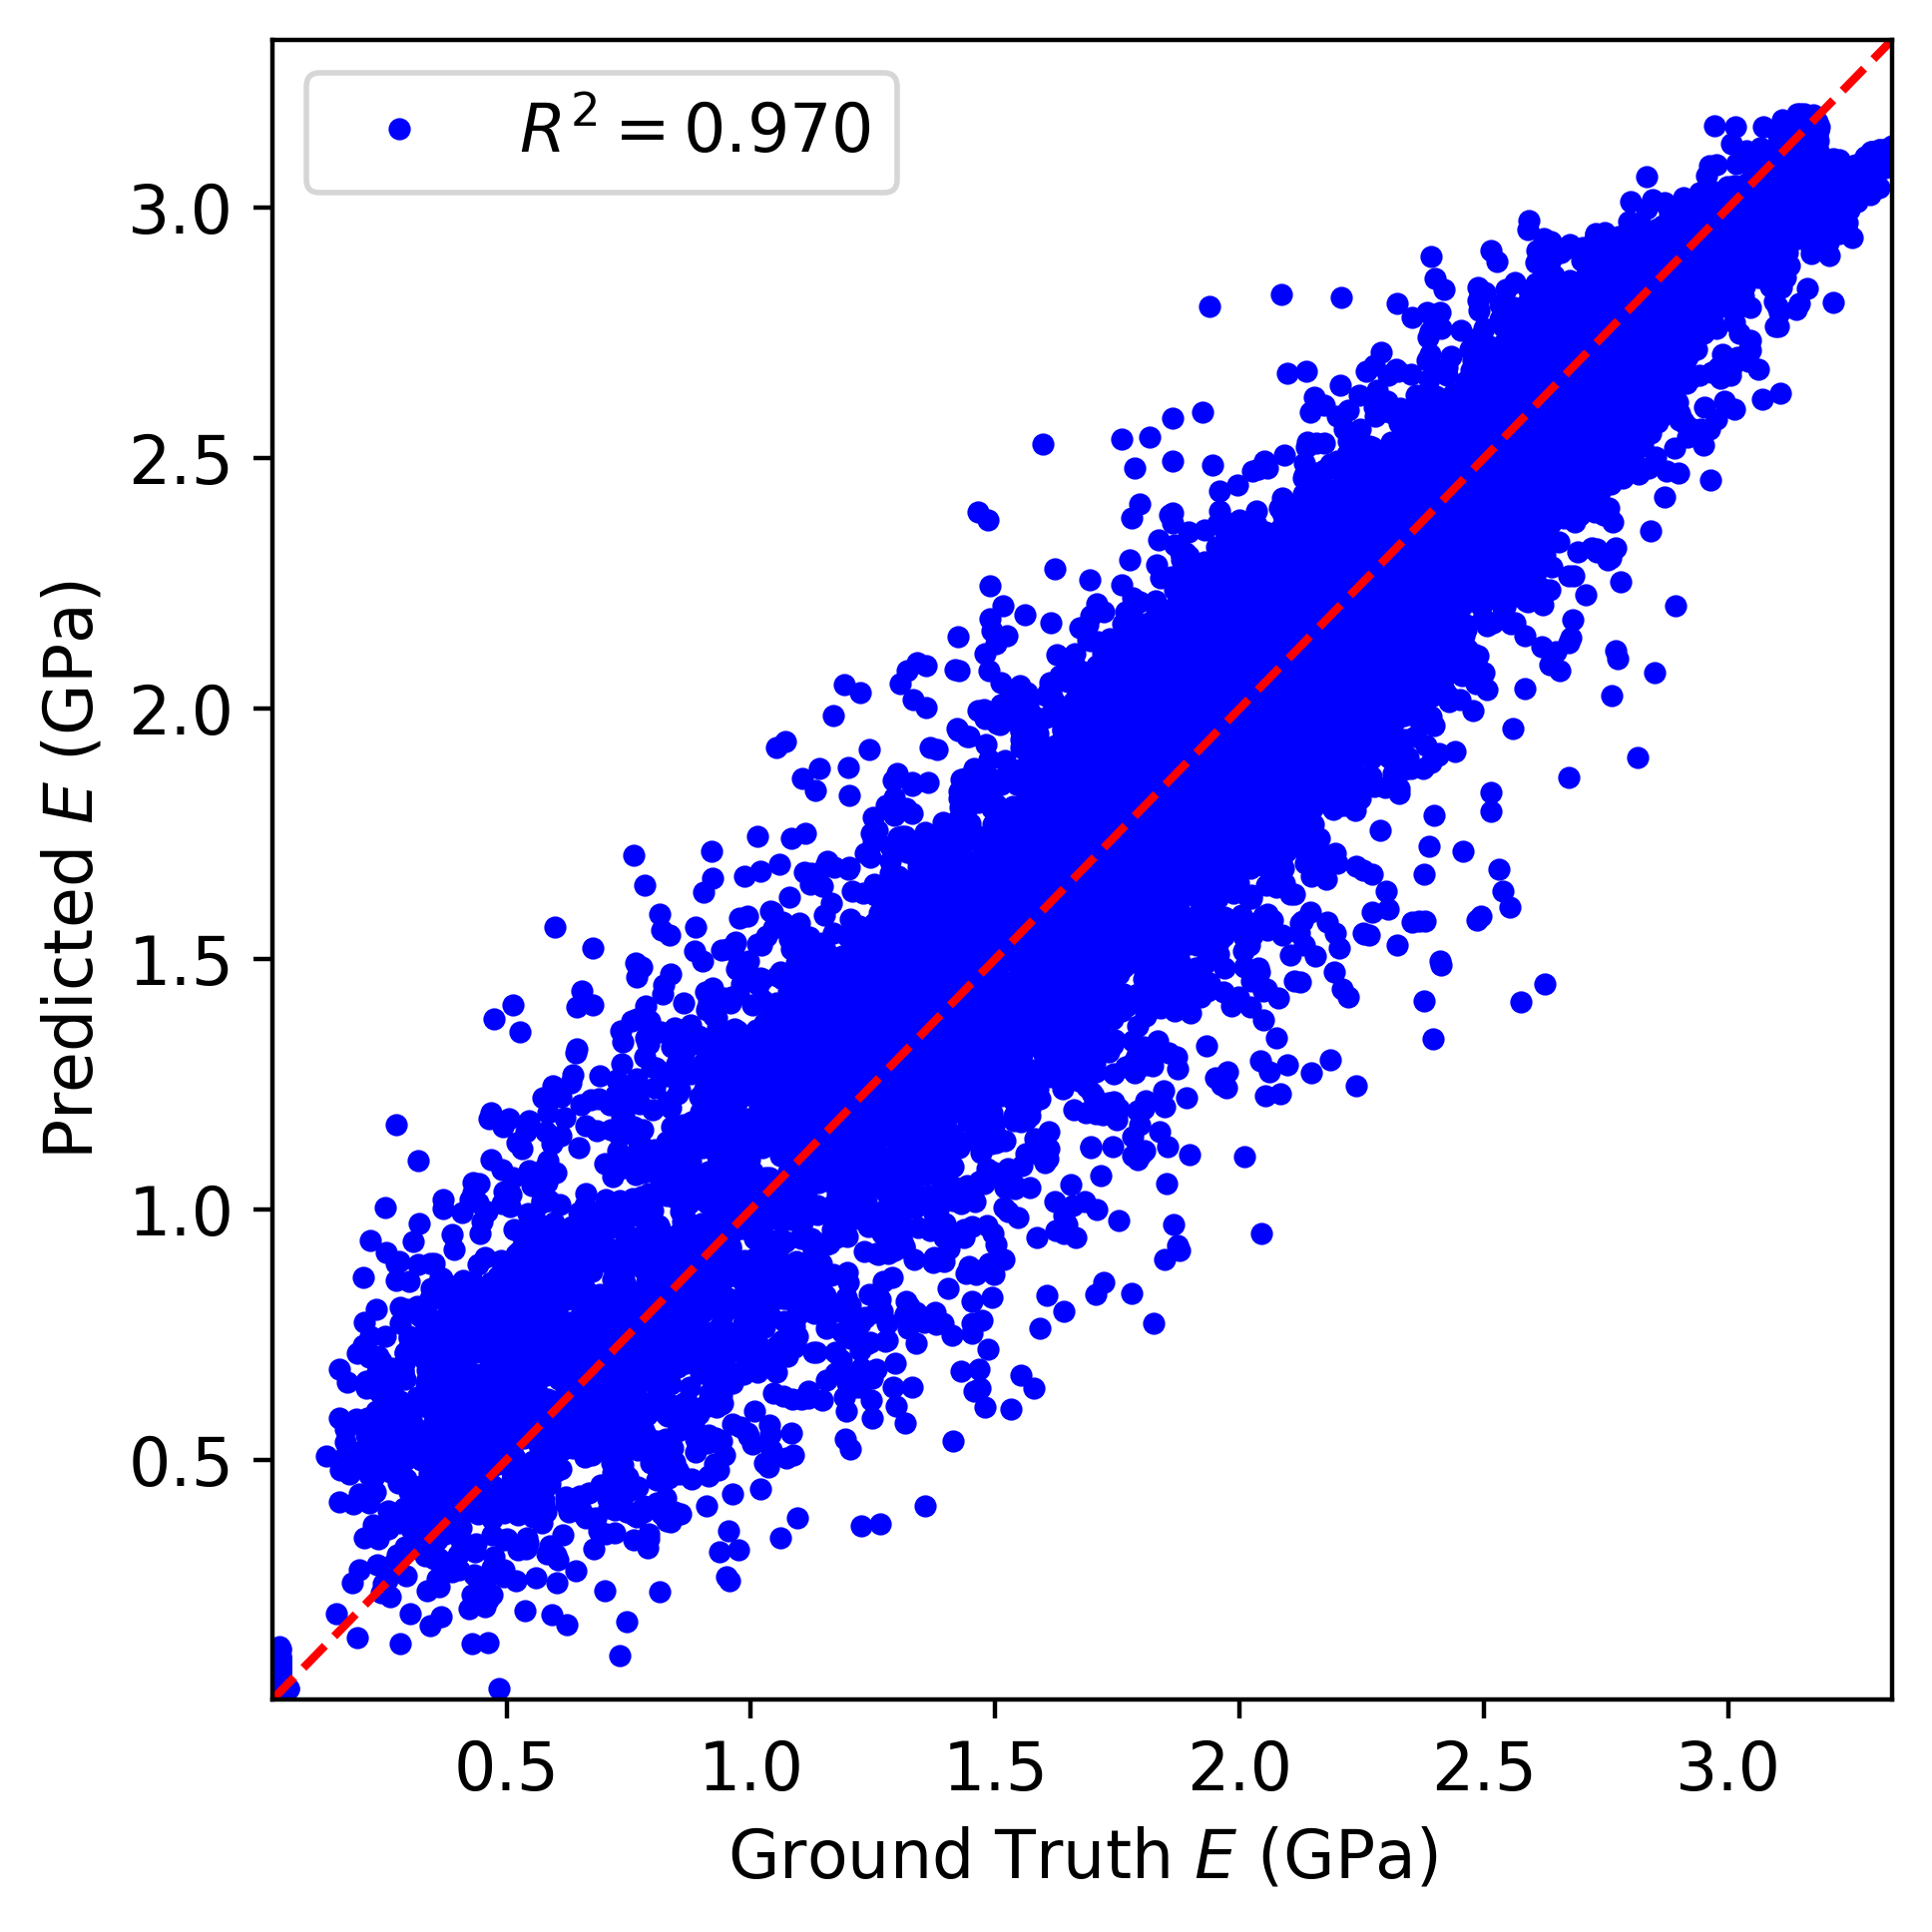

In [27]:
R2 = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.9668250559564536


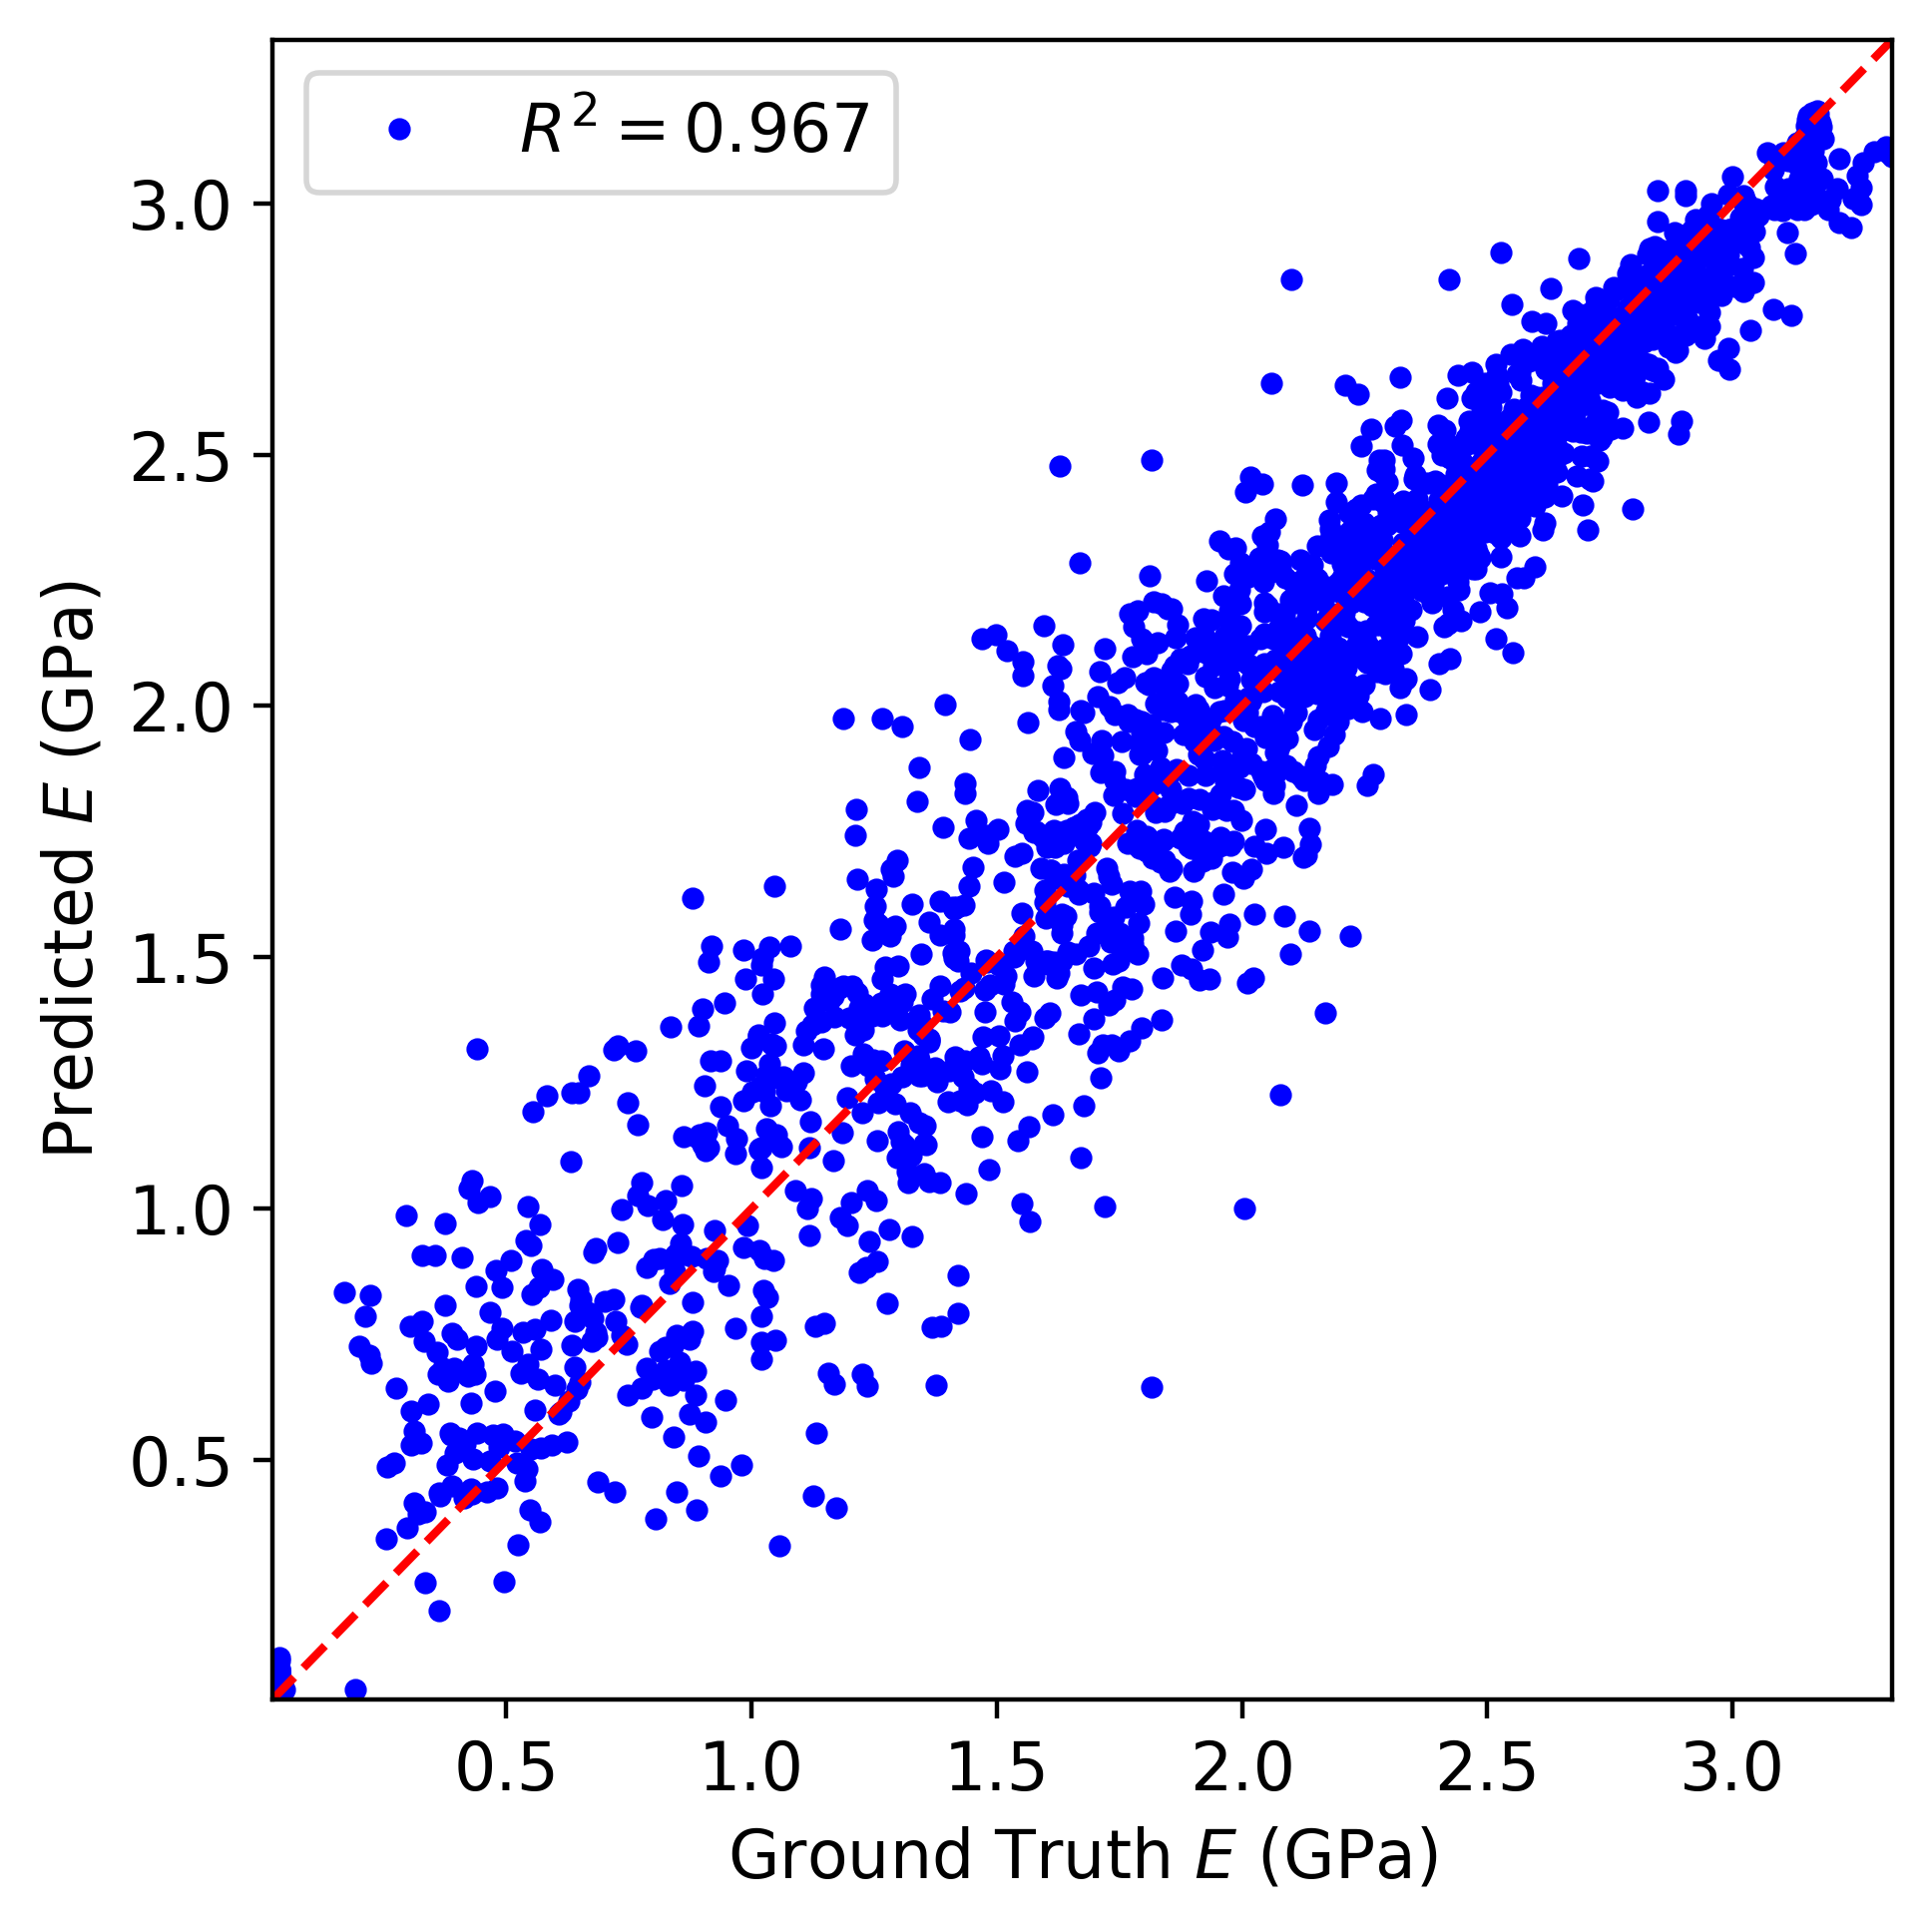

In [28]:
R2 = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

## Testing data

Test R2 for E: 0.9674577616702973


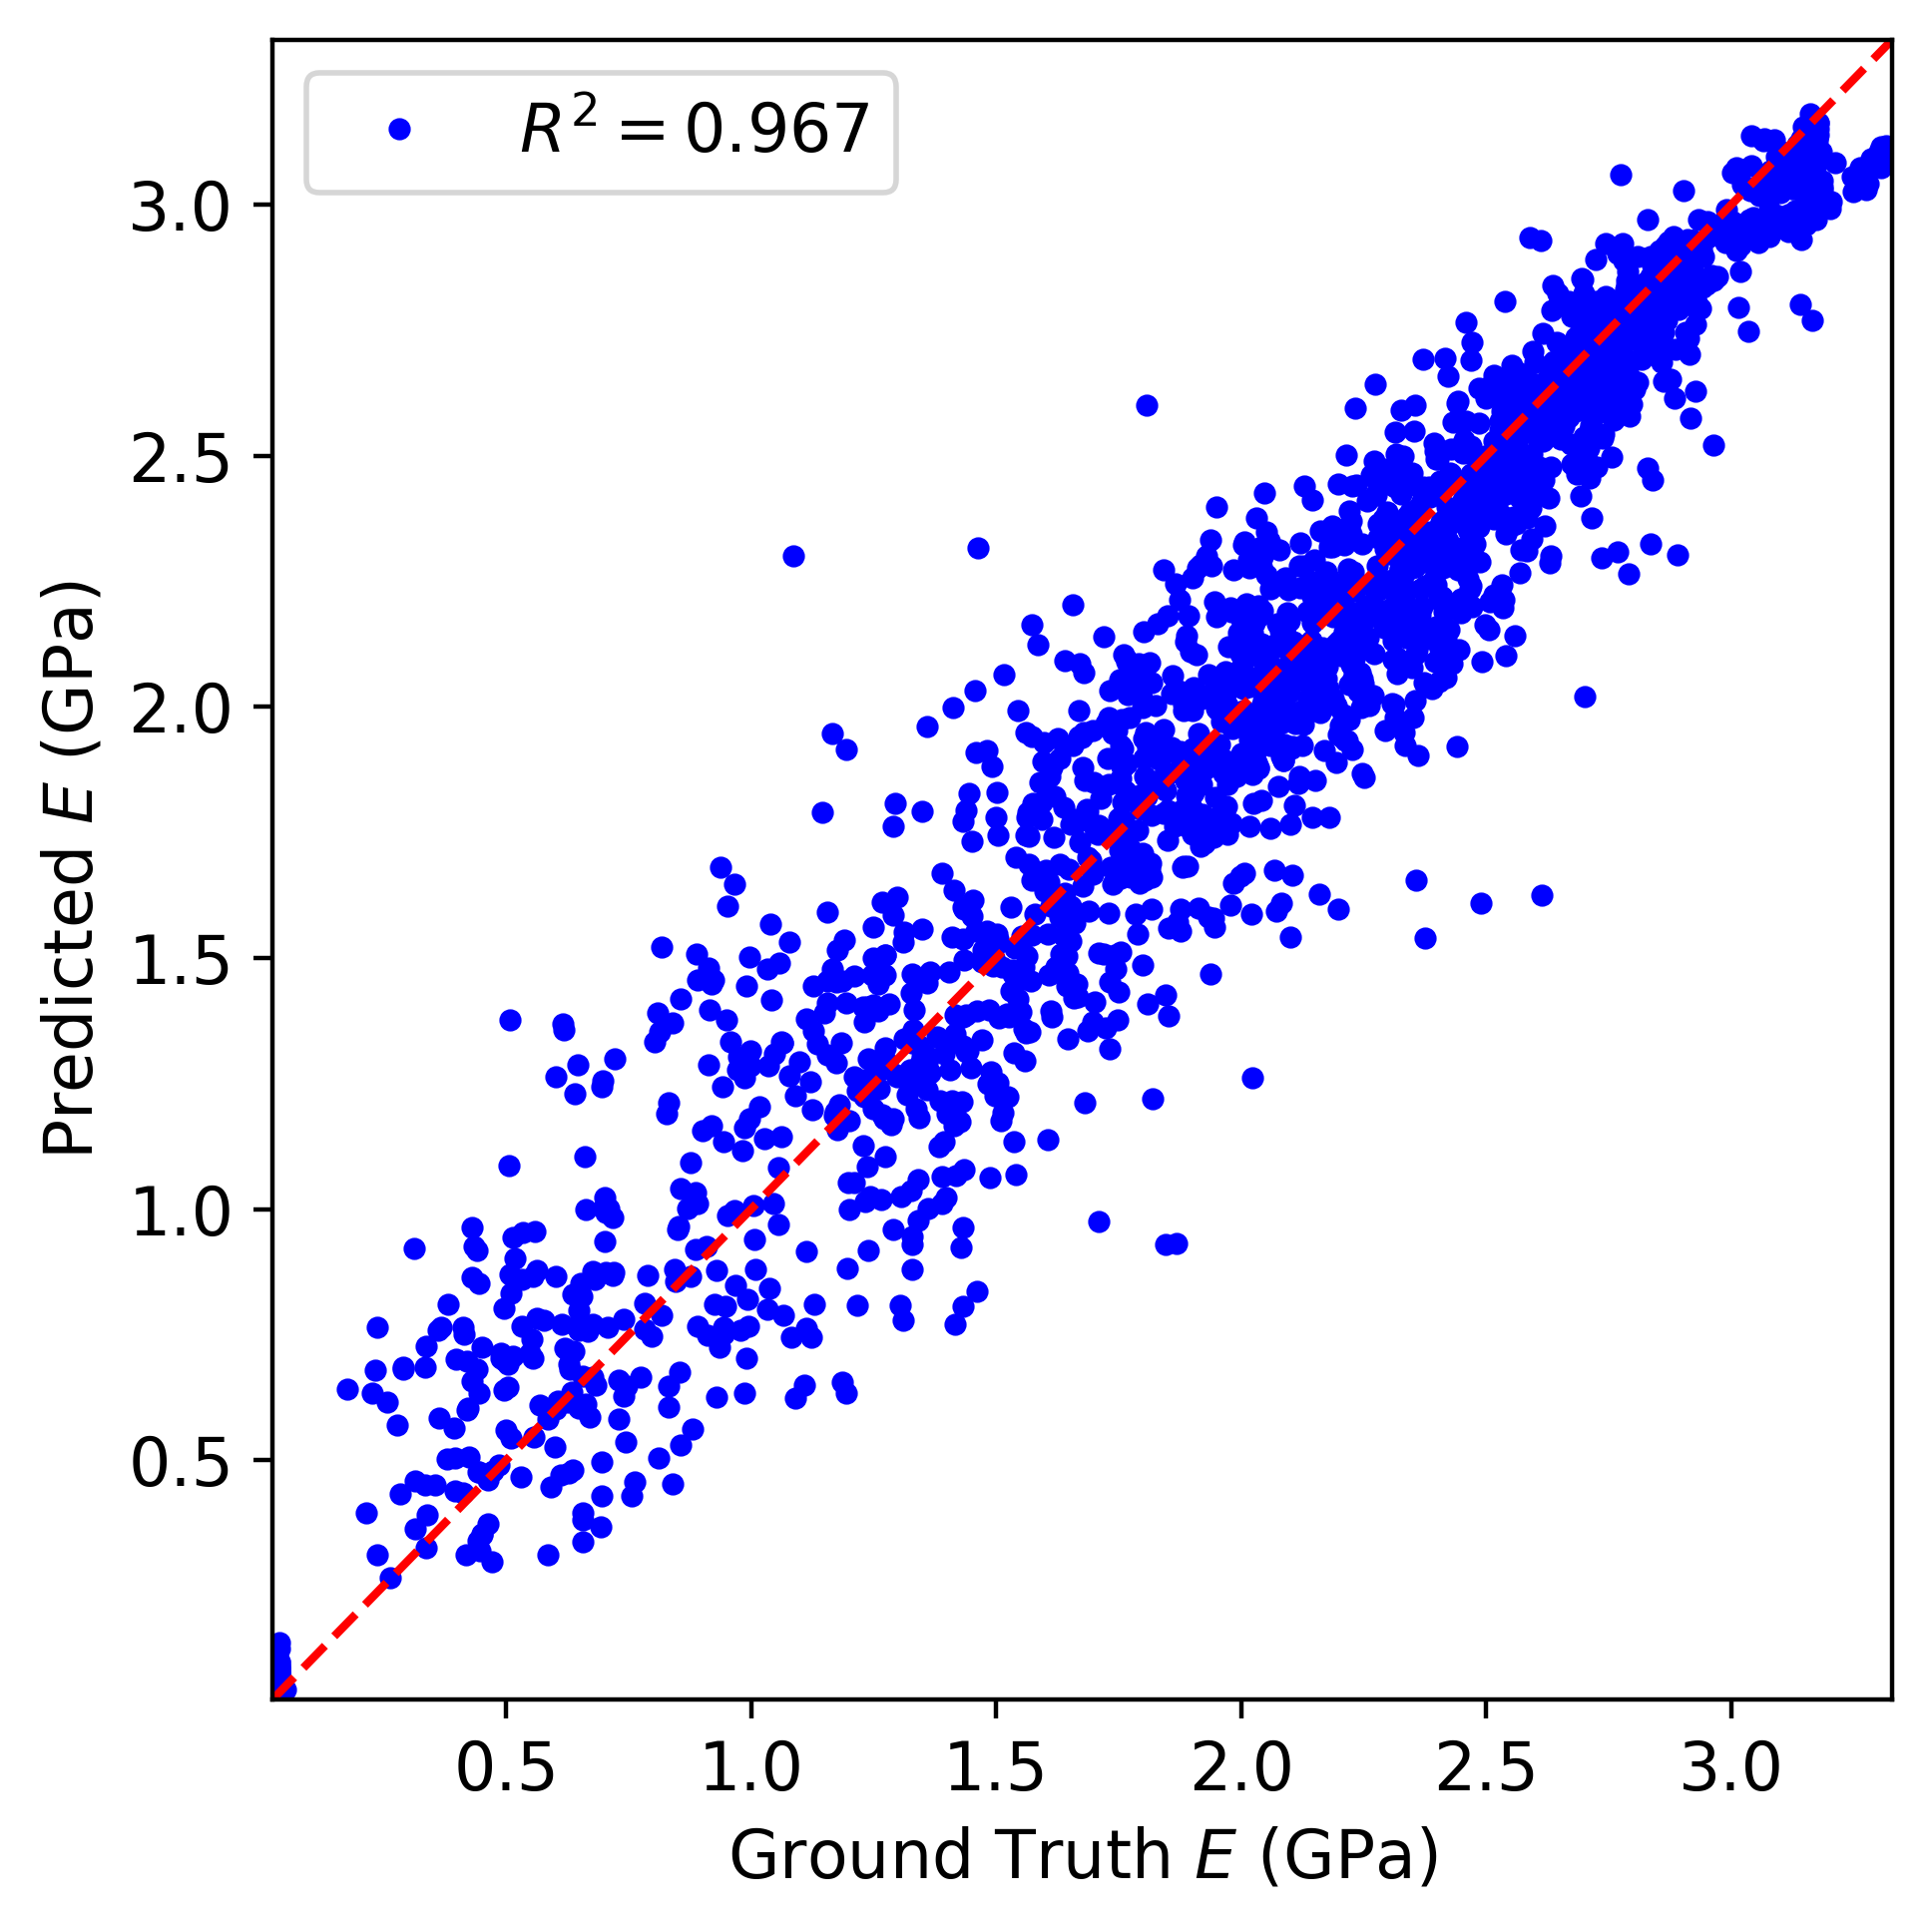

In [29]:
R2 = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)